In [1]:
# This notebook analyzes cookies from crawl NL
# (Run with Python 3.6.1 |Anaconda 4.4.0 )

# The crawl includes 1 vantage points and top 1000 websites (no DNT).
# The aim is to understanding cookie-variations well enough to design a good country-cookie-metric.
# (E.g., one site, cookie variations for site based on vantage, and between sites, top-3rd parties, ...)
# (Later, this metric will be linked with site and country characteristics in a regression model.)

%pylab inline --no-import-all 
import pandas as pd
import sqlite3
from time import time
from datetime import datetime
import numpy as np
#from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from tldextract import extract as tldextract  # pip install tldextract
DPI = 120  # used for graphs. check at: http://www.infobyip.com/detectmonitordpi.php

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Read successful crawls
#Connection to the SQLite Database
con = sqlite3.connect('./crawl-data-NL-lite.sqlite')
#Query to get all websites and bool_success and add them in a dataframe 
sites=pd.read_sql_query("""SELECT s.`index` site, bool_success 
                        FROM site_info s LEFT JOIN CrawlHistory h
                        ON s.`index`=replace(replace(h.arguments, 'http://', ''), 'https://', '') 
                        AND command='GET' WHERE site!='SELF'""", con)
#sites.head()
sites.count()


site            1004
bool_success    1004
dtype: int64

In [3]:
# Load the measurement data / cookies
#Connect to SQLite Database
con = sqlite3.connect('crawl-data-NL-lite.sqlite')
#Query to get all cookies and add them in a dataframe
cookies=pd.read_sql_query("""SELECT site_url, host, name, value, is_session, change, expiry, creationTime
                          FROM site_visits s LEFT JOIN javascript_cookies c 
                          ON s.visit_id=c.visit_id ORDER BY s.visit_id""", con)
cookies

,site_url,host,name,value,is_session,change,expiry,creationTime
0,http://iplocation.net,.iplocation.net,visid_incap_877543,vn9k4KmbT3q8PTD9ZvAbMSy6U1gAAAAAQUIPAAAAAAC0jy...,0.0,added,2017-12-15 08:42:55,2016-12-16 04:55:56
1,http://iplocation.net,.iplocation.net,incap_ses_553_877543,/m5KI4ZsDUHVUOWxnaasByy6U1gAAAAATdDcif9xagPLSc...,1.0,added,9999-12-31 23:59:59,2016-12-16 04:55:56
2,http://iplocation.net,.google.com,NID,92=S0VAPYawh6bjdA9BXwkOdYZ7INXw2fnroV8xJRjIk5q...,0.0,added,2017-06-17 05:55:57,2016-12-16 04:55:57
3,http://iplocation.net,incapsula.evyy.net,AWSALB,bKAKrIUjYpu7NaixJDbQWzjzlaQCBj6zmKWbIS6JNiQPpW...,0.0,added,2016-12-23 04:55:58,2016-12-16 04:55:58
4,http://iplocation.net,.doubleclick.net,test_cookie,CheckForPermission,0.0,added,2016-12-16 05:10:59,2016-12-16 04:55:59
5,http://iplocation.net,www.ojrq.net,AWSELB,EDDFA3C716DF45E51FCA94B55E54BBC0A30D7B2F1A09E7...,0.0,added,2016-12-16 05:55:59,2016-12-16 04:55:59
6,http://iplocation.net,.doubleclick.net,IDE,AHWqTUkXVSZblUtFyFxaznNiviVis-EPGpST7kvxYP_Djp...,0.0,added,2018-12-16 04:55:59,2016-12-16 04:55:59
7,http://iplocation.net,.doubleclick.net,id,245eff59d5c18b50||t=1481882159|et=730|cs=00221...,0.0,added,2018-12-16 04:55:59,2016-12-16 04:55:59
8,http://iplocation.net,.evyy.net,brwsr,6dec57f9-4e15-bbc4-3447-feae74112d0d,0.0,added,2021-12-15 04:55:59,2016-12-16 04:55:59
9,http://iplocation.net,.ojrq.net,brwsr,6dec57f9-4e15-bbc4-3447-feae74112d0d,0.0,added,2021-12-15 04:55:59,2016-12-16 04:55:59


In [4]:
# Two functions that Hadi had to extract domains 

#Function to remove the http, https of site_url
def strip_site(site):
    """Removes leading http:// or https:// and trailing '/'"""
    site = site.lower()
    if site.startswith('http'):
        site = site.replace('https://', '').replace('http://', '')
    if site.endswith('/'):
        site = site[:-1]
    return site

#Function to strip and extract the domains of site_url
def extract_domain(site):
    """Returns domain+tld from a full domain"""
    site = strip_site(site)  # just to be sure
    ext = tldextract(site)
    ret = ".".join([ss for ss in ext[-2:] if ss])
    # In case of gov.ie, or IPs, our 'ret' works better than 'ext.registered_domain'
    return ret

#Function to extract the domains of host
def extract_host(host):
    """Returns domain+tld from a full domain"""
    ext = tldextract(host)
    ret = ".".join([ss for ss in ext[-2:] if ss])
    return ret

#extract the domains to compare them
cookies[["site_url", "host"]] = cookies[["site_url", "host"]].astype(str) 
cookies['site_url']=cookies.site_url.apply(extract_domain)
cookies['host']=cookies.host.apply(extract_host)

#Compare 3rd party domains and the website and leave only the ones that are different
comparison_1pd = cookies["site_url"] == cookies["host"]
cookies['comparison_1pd']=comparison_1pd
cookies = cookies[cookies.comparison_1pd == False]


#convert dates and get only cookies that expire in more than 30 days.
cookies.loc[:,"expiry"] = cookies["expiry"].astype('datetime64[ns]') #I do not know why using loc and overwriting still confuse the copy with view
cookies.loc[:,"creationTime"] = cookies["creationTime"].astype('datetime64[ns]')
cookies["timediff"] = cookies.loc[:,"expiry"] - cookies.loc[:,"creationTime"] 
timevar=pd.Timedelta(30,unit='d') #eg. for hours pd.Timedelta(6,unit='h')
cookies["timediff_check"]= cookies.timediff>timevar
cookies = cookies[cookies.timediff_check == True]


#Just to check the count of the values
#x=cookies.is_session.value_counts() #it only remains the non session
#x
cookies.sort_values('site_url')


unable to cache TLDs in file /opt/miniconda3/lib/python3.6/site-packages/tldextract/.tld_set: [Errno 13] Permission denied: '/opt/miniconda3/lib/python3.6/site-packages/tldextract/.tld_set'
/opt/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value i

,site_url,host,name,value,is_session,change,expiry,creationTime,comparison_1pd,timediff,timediff_check
27724,01net.com,crwdcntrl.net,_cc_cc,"""ACZ4nGNQSDQxNLQwSU5KMbZIMTdPNkpJS04zTUm1SE01M...",0.0,changed,2017-09-12 06:09:51,2016-12-16 05:09:47,False,270 days 01:00:04,True
27477,01net.com,stickyadstv.com,UID,1d50aaf6b5ce545f650842c453603,0.0,changed,2017-01-15 05:10:04,2016-12-16 05:09:42,False,30 days 00:00:22,True
27478,01net.com,revsci.net,rts_AAAA,MLs3rFVv8l9jZbAk5wsDYOKrQtp1wk4KItvGY/jb1HBdsZ...,0.0,changed,2017-12-16 05:09:43,2016-12-16 05:09:42,False,365 days 00:00:01,True
27479,01net.com,revsci.net,rts_AAAA,MLs3rFVv8l9jZbAk5wsDYOKrQtp1wk4KItvGY/jb1HBdsZ...,0.0,changed,2017-12-16 05:09:52,2016-12-16 05:09:42,False,365 days 00:00:10,True
27480,01net.com,revsci.net,NETID01,42fff3c0a48e8ba3988d4c32558c3616,0.0,changed,2018-01-10 05:09:43,2016-12-16 05:09:42,False,390 days 00:00:01,True
27505,01net.com,adnxs.com,uuid2,8204708809693508281,0.0,changed,2017-03-16 06:09:44,2016-12-16 05:09:43,False,90 days 01:00:01,True
27506,01net.com,adnxs.com,uuid2,8204708809693508281,0.0,changed,2017-03-16 06:09:45,2016-12-16 05:09:43,False,90 days 01:00:02,True
27507,01net.com,adnxs.com,uuid2,8204708809693508281,0.0,changed,2017-03-16 06:09:46,2016-12-16 05:09:43,False,90 days 01:00:03,True
27508,01net.com,adnxs.com,uuid2,8204708809693508281,0.0,changed,2017-03-16 06:09:47,2016-12-16 05:09:43,False,90 days 01:00:04,True
27509,01net.com,adnxs.com,uuid2,8204708809693508281,0.0,changed,2017-03-16 06:09:48,2016-12-16 05:09:43,False,90 days 01:00:05,True


In [5]:
#count of unique third party domains in each website
unique_tpd=cookies.groupby('site_url')['host'].nunique()
print(unique_tpd)
x=unique_tpd.agg(['mean', 'max', 'min','std'])
x

site_url
01net.com                  67
123movies.to               11
1und1.de                    6
20minutes.fr               65
2performant.com             1
3bmeteo.com                 6
4tuning.ro                  5
888casino.com              11
9gag.com                   13
a1.net                      5
a1.ro                      17
ablogica.com                1
abnamro.nl                  1
accuweather.com             3
ad.nl                       3
addthis.com                 1
adevarul.ro                 8
adf.ly                      3
adlibris.com                2
adobe.com                  19
adscale.de                  1
adverts.ie                  8
aerlingus.com              12
aftonbladet.se             22
agerpres.ro                 2
ah.nl                       1
aib.ie                      2
airbnb.co.uk                6
airbnb.fr                   4
airbnb.ie                   4
                           ..
wp.pl                      20
wpolityce.pl               13
w

mean    13.145161
max     89.000000
min      1.000000
std     16.992655
Name: host, dtype: float64

In [6]:
#count all cookies in each website 
cookies_count=cookies.groupby('site_url')['host'].count() 
print(cookies_count)
y=cookies_count.agg(['mean', 'max', 'min','std'])
y


site_url
01net.com                  495
123movies.to                37
1und1.de                    12
20minutes.fr               367
2performant.com              1
3bmeteo.com                 11
4tuning.ro                   9
888casino.com               19
9gag.com                    39
a1.net                       9
a1.ro                       80
ablogica.com                 1
abnamro.nl                   3
accuweather.com              4
ad.nl                       12
addthis.com                  2
adevarul.ro                 14
adf.ly                      11
adlibris.com                 2
adobe.com                   87
adscale.de                   2
adverts.ie                  21
aerlingus.com               32
aftonbladet.se             132
agerpres.ro                  2
ah.nl                        2
aib.ie                       6
airbnb.co.uk                12
airbnb.fr                    9
airbnb.ie                    9
                          ... 
wp.pl                       67

mean     53.022333
max     736.000000
min       1.000000
std      97.028891
Name: host, dtype: float64

In [10]:
#The 30 most common third party domains on websites
tpd=cookies['host'].value_counts()
tpd.iloc[1:30,]

adnxs.com                2923
rubiconproject.com       2880
smartadserver.com        1710
doubleclick.net          1601
adsrvr.org               1213
pubmatic.com             1138
krxd.net                  989
revsci.net                822
mookie1.com               790
360yield.com              781
advertising.com           774
rfihub.com                721
demdex.net                701
gemius.pl                 688
turn.com                  659
rlcdn.com                 641
gwallet.com               612
bidswitch.net             581
adform.net                510
atemda.com                506
stickyadstv.com           468
addthis.com               424
openx.net                 417
quantserve.com            410
facebook.com              399
adscale.de                397
scorecardresearch.com     389
contextweb.com            386
adition.com               386
Name: host, dtype: int64

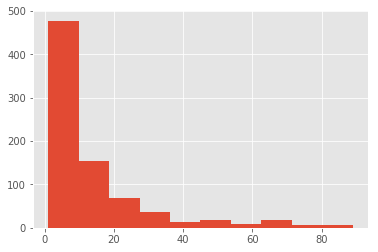

In [11]:
#Histogram of the number of unique third party domains (per website)
unique_tpd.hist()

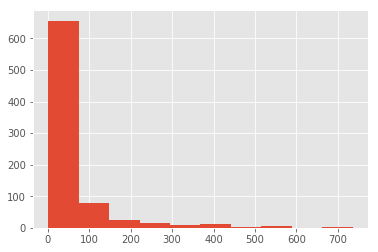

In [12]:
#Histogram of the count of all cookies (per website)
cookies_count.hist()


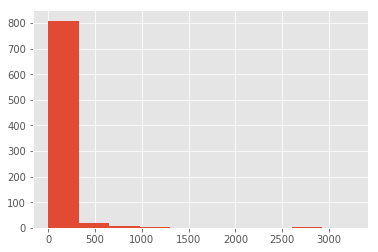

In [13]:
#Most common third party domains histogram
tpd.hist()

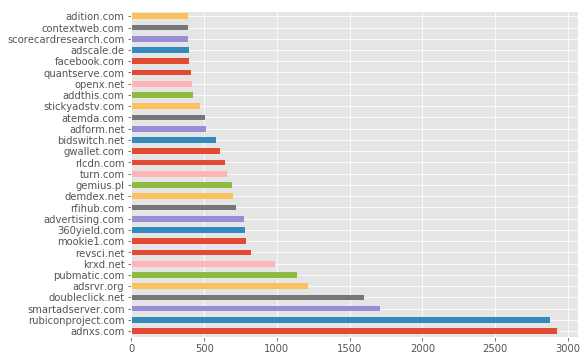

In [14]:
#Most common third party domains (total cookies over all sites)
plt.figure(figsize=(8,6))
(tpd.iloc[1:30,]).plot(kind='barh')